# А/B-тестирование

**Цель: провести оценку результатов A/B-теста и вернуться с итоговыми выводами/рекомендациями. Тест подразумевал увеличение конверсии по каждой метрике на 10 и более %**

**А — контрольная, B — новая платёжная воронка**

**Техническое задание:**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**План исследования**
Шаг 1. Первичное знакомство
Шаг 2. Предобработка данных:
Шаг 3. Исследовательский анализ данных:
Шаг 4. Оценить результаты A/B-тестирования
Шаг 5. Описать выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделать общее заключение о корректности проведения теста

## Первичное знакомство

In [1]:
%pip install -U kaleido -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
#загрузим библиотеки
import pandas as pd
import scipy.stats as stats
import math as mth
import datetime as dt
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default="png"
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

import warnings
warnings.simplefilter('ignore')

In [3]:
#загрузим датафрейм - календарь маркетинговых событий на 2020 год
try:
    ab_project_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
except:
    ab_project_marketing_events = pd.read_csv(r"C:\scripts\ab_project_marketing_events.csv")
    
ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
#загрузим датафрейм - действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
try:
    final_ab_events = pd.read_csv('/datasets/final_ab_events.csv')
except:
    final_ab_events = pd.read_csv(r"C:\scripts\final_ab_events.csv")

final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [5]:
#загрузим датафрейм - пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года
try:
    final_ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
except:
    final_ab_new_users = pd.read_csv(r"C:\scripts\final_ab_new_users.csv")

final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
#загрузим датафрейм - таблица участников тестов
try:
    final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    final_ab_participants = pd.read_csv(r"C:\scripts\final_ab_participants.csv")

final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


## Предобработка данных

In [7]:
list = ab_project_marketing_events, final_ab_events, final_ab_new_users, final_ab_participants

for row in list:
    row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id    

In [8]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'], format='%Y-%m-%d')

In [9]:
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'], format='%Y-%m-%d')

In [10]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'], format='%Y-%m-%dT%H:%M:%S')

In [11]:
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'], format='%Y-%m-%d')

In [12]:
list = ab_project_marketing_events, final_ab_events, final_ab_new_users, final_ab_participants

for row in list:
    row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732


In [13]:
#проверим на пропуски
list = [ab_project_marketing_events, final_ab_events, final_ab_new_users, final_ab_participants]

for row in list:
    print(row.isna().sum())

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
user_id       0
first_date    0
region        0
device        0
dtype: int64
user_id    0
group      0
ab_test    0
dtype: int64


Видим пропуски в final_ab_events в поле details

In [14]:
#проверим на дубликаты
list = ab_project_marketing_events, final_ab_events, final_ab_new_users, final_ab_participants

for row in list:
    print('Кол-во дубликатов -', row.duplicated().sum())

Кол-во дубликатов - 0
Кол-во дубликатов - 0
Кол-во дубликатов - 0
Кол-во дубликатов - 0


Дубликаты отсутствуют

In [15]:
#посмотрим столбец с датой и временем события
final_ab_events[['event_dt']].describe()

,event_dt
count,440317
unique,267268
top,2020-12-14 18:54:55
freq,10
first,2020-12-07 00:00:33
last,2020-12-30 23:36:33


Тест закончился раньше. Должен был 4 января, а в итогк 30 декабря. Интересно почему?

In [16]:
#посмотрим столбец с датой и временем регистрации
usr_test = final_ab_participants[final_ab_participants['ab_test'] == 'recommender_system_test']
usr_test_ab = usr_test.merge(final_ab_new_users, on='user_id', how='inner')

usr_test_ab[['first_date']].describe()

,first_date
count,6701
unique,15
top,2020-12-21 00:00:00
freq,723
first,2020-12-07 00:00:00
last,2020-12-21 00:00:00


Мы владеем данными с 7.12 по 21.12

In [17]:
#проверка условия ТЗ - 15% новых пользователей из региона EU
#считаем кол-во зарегистрированных пользователей с 7.12 по 21.12
new_usr_eu = final_ab_new_users[(final_ab_new_users['region']=='EU') 
                                  & (final_ab_new_users['first_date'] <= '2020-12-21')]['user_id'].nunique()
print ('Кол-во новых пользоватлей из EU', new_usr_eu)

Кол-во новых пользоватлей из EU 42340


In [18]:
#проверим исходный датафрейм по уникальным значениям тестов
final_ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [19]:
#посчитаем кол-во участников теста recommender_system_test из EU
usr_test_ab_eu = usr_test_ab[usr_test_ab['region'] == 'EU']['user_id'].nunique()
print ('Кол-во новых пользователей из EU в тесте -', usr_test_ab_eu)

Кол-во новых пользователей из EU в тесте - 6351


In [20]:
print('Доля пользователей из EU -', round(usr_test_ab_eu/new_usr_eu * 100), '%')

Доля пользователей из EU - 15 %


Условие ТЗ о 15% новых пользователей, которые должны быть из региона EU соблюдено

In [21]:
print ('Кол-во уникальных пользователей - ', usr_test_ab['user_id'].nunique())

Кол-во уникальных пользователей -  6701


In [22]:
#проверим, что нет пересечений с конкурирующим тестом
usr_test_ab.groupby('group')['user_id'].nunique()

group
A    3824
B    2877
Name: user_id, dtype: int64

In [23]:
total_A = usr_test_ab.query('group == "A"')['user_id'].nunique()
total_B = usr_test_ab.query('group == "B"')['user_id'].nunique()

print('Группа А больше группы В на -', round(total_A/total_B*100)-100, '%')

Группа А больше группы В на - 33 %


Между группами нет пересечений, сумма равняется общему количеству пользователей. Но группы распределены неравномерно, группа А больше на 33% группы B

In [24]:
duplicate = (
    final_ab_participants.groupby('user_id')
    .agg({'ab_test': 'nunique'})
    .sort_values(by='ab_test', ascending=False)
    .reset_index()
    .query('ab_test == 2')
)
print ('Кол-во пользователей, которые пересекаются -', duplicate['user_id'].nunique())

Кол-во пользователей, которые пересекаются - 1602


1602 пользователя фигурируют в обоих тестах, необходимо удалить их из теста

In [25]:
#удалим пользователей, которые участвуют в двух тестах одновременно
usr_test_ab_group = (
    usr_test_ab.query('user_id not in @duplicate["user_id"]')
                        .groupby('group')['user_id']
                        .nunique()
)
usr_test_ab_group

group
A    2903
B    2196
Name: user_id, dtype: int64

In [26]:
total_A_new = usr_test_ab.query('user_id not in @duplicate["user_id"] and group=="A"')['user_id'].nunique()
total_B_new = usr_test_ab.query('user_id not in @duplicate["user_id"] and group=="B"')['user_id'].nunique()

print('Группа А больше группы В на -', round(total_A_new/total_B_new*100)-100, '%')

Группа А больше группы В на - 32 %


Группы распределены неравномерно, группа А больше группа В на 32%. После очистки датафрейма выборка уменьшилась и составляет уже 5099

In [27]:
#итоговый датафрейм
usr_test_ab_new =  usr_test_ab.query('user_id not in @duplicate["user_id"]')
usr_test_ab_new

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC
5,4FF2998A348C484F,A,recommender_system_test,2020-12-20,EU,Mac
6,7473E0943673C09E,A,recommender_system_test,2020-12-16,EU,iPhone
...,...,...,...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test,2020-12-10,N.America,Android
6697,9D263B8EF15CF188,B,recommender_system_test,2020-12-16,N.America,Mac
6698,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18,APAC,Mac
6699,29C92313A98B1176,B,recommender_system_test,2020-12-07,APAC,Android


In [28]:
#соединим логи с событиями и итоговый датафрейм с пользователями
test_ab_new = usr_test_ab_new.merge(final_ab_events, on='user_id', how='left')
test_ab_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21115 entries, 0 to 21114
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     21115 non-null  object        
 1   group       21115 non-null  object        
 2   ab_test     21115 non-null  object        
 3   first_date  21115 non-null  datetime64[ns]
 4   region      21115 non-null  object        
 5   device      21115 non-null  object        
 6   event_dt    18804 non-null  datetime64[ns]
 7   event_name  18804 non-null  object        
 8   details     2483 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.6+ MB


Пропуски есть в столбцах event_dt и event_name, т.е. данные клиенты только зарегистрировались и дальше не продвинулись

In [29]:
#заполним пропуски в event_name значением registration
test_ab_new['event_name'] = test_ab_new['event_name'].fillna('registration')
test_ab_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21115 entries, 0 to 21114
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     21115 non-null  object        
 1   group       21115 non-null  object        
 2   ab_test     21115 non-null  object        
 3   first_date  21115 non-null  datetime64[ns]
 4   region      21115 non-null  object        
 5   device      21115 non-null  object        
 6   event_dt    18804 non-null  datetime64[ns]
 7   event_name  21115 non-null  object        
 8   details     2483 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.6+ MB


Заполнили пропуски в поле event_name значением registration, т.к. пользователи, которые остановились на регистрации нам тоже полезны

In [30]:
#заполним пропуски в event_dt значением из first_date
test_ab_new['event_dt'] = test_ab_new['event_dt'].fillna(test_ab_new['first_date'])
test_ab_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21115 entries, 0 to 21114
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     21115 non-null  object        
 1   group       21115 non-null  object        
 2   ab_test     21115 non-null  object        
 3   first_date  21115 non-null  datetime64[ns]
 4   region      21115 non-null  object        
 5   device      21115 non-null  object        
 6   event_dt    21115 non-null  datetime64[ns]
 7   event_name  21115 non-null  object        
 8   details     2483 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.6+ MB


Заполнили пропуски в поле event_dt значением из first_date, т.к. кроме регистрации, у пользователей событий не было, значит можно считать, что first_date равен event_dt

In [31]:
#добавим поле с датами событий
test_ab_new.insert(7, 'day', test_ab_new['event_dt'].dt.day, True)
test_ab_new

,user_id,group,ab_test,first_date,region,device,event_dt,day,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,7,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,25,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,7,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,25,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,7,product_page,NaN
...,...,...,...,...,...,...,...,...,...,...
21110,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-07 10:12:15,7,login,NaN
21111,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-08 22:51:16,8,login,NaN
21112,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-09 02:28:03,9,login,NaN
21113,6715343AFBA285AE,B,recommender_system_test,2020-12-07,CIS,Android,2020-12-10 22:55:14,10,login,NaN


In [32]:
#посмотрим, что все 5099 уникальных клиентов фигурируют в итоговом датафрейм с логами
total_test = test_ab_new['user_id'].nunique()
total_test

5099

In [33]:
#посмотрим сколько всего событий в итоговом датафрейме
total = test_ab_new['event_name'].count()
total

21115

In [34]:
ab_project_marketing_events.sort_values(by='start_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


In [35]:
#удалим события,которые произошли через 14 после регистрации
test_ab_new['delta'] = test_ab_new['event_dt'] -  test_ab_new['first_date']
d15 = pd.Timedelta(days=15)
test_ab_new = test_ab_new[test_ab_new[ 'delta' ] <= d15].copy()
print('Всего событий в итоговом датафрейме -', test_ab_new['event_name'].count())

Всего событий в итоговом датафрейме - 20640


In [36]:
print('Удалено -', round(100-(test_ab_new['event_name'].count()/total*100)),'%')

Удалено - 2 %


Удалено 2% от изначального кол-ва событий

In [37]:
test_ab_new.sort_values(by='delta', ascending=False)

,user_id,group,ab_test,first_date,region,device,event_dt,day,event_name,details,delta
14903,6E3DF9C69A6B607E,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-28 23:22:32,28,product_page,NaN,14 days 23:22:32
14910,6E3DF9C69A6B607E,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-28 23:22:32,28,login,NaN,14 days 23:22:32
14896,6E3DF9C69A6B607E,A,recommender_system_test,2020-12-14,EU,iPhone,2020-12-28 23:22:32,28,product_cart,NaN,14 days 23:22:32
4289,EAA6967BB9807DF2,A,recommender_system_test,2020-12-08,EU,PC,2020-12-22 22:54:40,22,product_page,NaN,14 days 22:54:40
4293,EAA6967BB9807DF2,A,recommender_system_test,2020-12-08,EU,PC,2020-12-22 22:54:38,22,login,NaN,14 days 22:54:38
...,...,...,...,...,...,...,...,...,...,...,...
19104,08530541B3E53C8A,B,recommender_system_test,2020-12-21,EU,iPhone,2020-12-21 00:00:00,21,registration,NaN,0 days 00:00:00
19105,3A8B9884EF17D2B3,A,recommender_system_test,2020-12-08,EU,iPhone,2020-12-08 00:00:00,8,registration,NaN,0 days 00:00:00
19106,E6BD9A774D155DEE,A,recommender_system_test,2020-12-08,EU,PC,2020-12-08 00:00:00,8,registration,NaN,0 days 00:00:00
19107,53F5CBB3C34747E5,A,recommender_system_test,2020-12-12,EU,iPhone,2020-12-12 00:00:00,12,registration,NaN,0 days 00:00:00


In [38]:
#распределение пользователей теста по региональной принадлежности
region = test_ab_new.groupby('region').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
region['ratio'] = round(region['user_id']/total_test*100, 2)
region

,user_id,ratio
region,,
EU,4749,93.14
N.America,223,4.37
APAC,72,1.41
CIS,55,1.08


Из EU 93%, N.America 4% и по APAC и CIS 1% 	

 - После удаления пересекающихся идентификаторов (id) мы потеряли 24% исходных данных 
 - События совершенны через 14 дней после даты регистрации
 - В результате фильтрации и удаления данных мы потеряли 2% событий от изначального количества
 - После очистки наблюдается неравномерное распределение пользователей между группами A и B: группа A больше на 32% по сравнению с группой B
 - Большинство пользователей (93%) — это Европа (EU). 4% пользователей находятся в Северной Америке (N.America), а по 1% пользователей находятся в других регионах — Азиатско-Тихоокеанском регионе (APAC) и СНГ (CIS)	
 - Из-за праздников тест закончился раньше, что повлияло на объем данных.

**С точки зрения соответствия ТЗ можно сделать следующие выводы:**
 - Частично соблюдены требования ТЗ в отношении дат начала и окончания теста, так как дата начала теста не была изменена, но тест закончился раньше запланированного срока;
 - Было соблюдено условие ТЗ, касающееся количества новых пользователей из региона EU: 15%
 - В связи с потерями данных после удаления пересекающихся id, ожидаемый объем выборки в 6000 человек не был достигнут полностью, однако достигнуто 5 тыс. пользователей, что составляет около 83% от запланированного
 - Было соблюдено условие ТЗ относительно проверки изменения метрик за 14 дней после регистрации пользователей.

## Иследовательский анализ данных

In [39]:
#посмотрим распределение кол-во событий на одного пользователя
test_ab_new.query('group == "A"').groupby('user_id').agg({'event_name':'count'}).describe()

,event_name
count,2903.000000
mean,5.263520
std,4.222507
min,1.000000
25%,1.000000
50%,4.000000
75%,8.000000
max,24.000000


In [40]:
test_ab_new.query('group == "B"').groupby('user_id').agg({'event_name':'count'}).describe()

,event_name
count,2196.000000
mean,2.440801
std,2.819013
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,24.000000


В группе А среднее кол-во событий равно 5,2, а медиана равна 4

В группе В среднее кол-во событий равно 2,4, а медиана равна 1

В обоих группах присутствуют выбросы, возможно один пользователь совершал несколько покупок

Для дальнейшего анализа будет использоваться медианное значение — в группе А оно равно 4 событиям, в группе B — 1 событию. Медиана в группе А значительно выше, чем в группе B

In [41]:
#посмотрим какие события есть в логах
test_ab_new.groupby('event_name').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False)

,user_id
event_name,
login,8274
product_page,5158
product_cart,2473
purchase,2424
registration,2311


Больше всего событий с получением логина, далее просмотр карточек, просмотр корзины и на четвертом месте покупка

In [42]:
#посмотрим сколько пользователей совершали каждое из этих событий
funnel_A = test_ab_new.query('group == "A"').groupby('event_name').agg({'user_id':'nunique'}).reset_index()
funnel_A

,event_name,user_id
0,login,2082
1,product_cart,631
2,product_page,1360
3,purchase,652
4,registration,821


- При построении воронки необходимо учитывать, что только 2903 события типа "регистрация" были зарегистрированы фактически;
- Только 2082 пользователя получили логин;
- Из них только 1360 пользователей посмотрели карточки;
- Далее 631 пользователя добавили товары в корзину;
- И только 652 пользователя осуществили покупку.

In [43]:
funnel_A.loc[4, 'user_id'] = 2903
funnel_A = funnel_A.reindex([4, 0, 2, 1, 3])
funnel_A

,event_name,user_id
4,registration,2903
0,login,2082
2,product_page,1360
1,product_cart,631
3,purchase,652


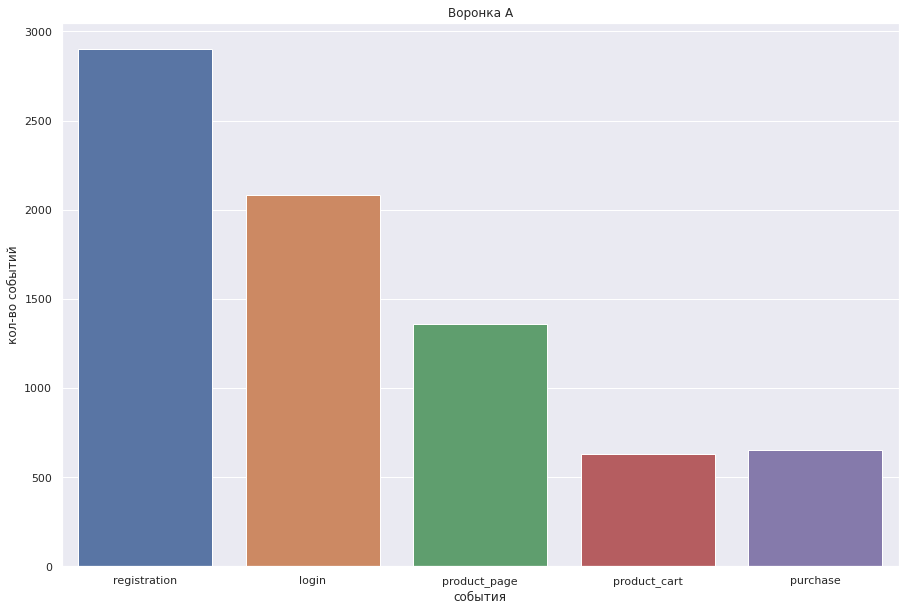

In [44]:
sns.barplot(data=funnel_A, x='event_name', y='user_id')
plt.title('Воронка А')
plt.xlabel('события')
plt.ylabel('кол-во событий')
plt.show()

Итоговая воронка по группе А - готова. Стоит отметить, что при событии "просмотр корзины" значение меньше, чем при событии "покупка". Вероятнее всего, это объясняется наличием альтернативного пути оплаты, который не требует использования корзины.

In [45]:
funnel_A['ratio_first'] = round(funnel_A['user_id']/total_A_new*100,2)
funnel_A['ratio_prev'] = round(funnel_A['user_id']/funnel_A['user_id'].shift(1, fill_value=0)*100,2)
funnel_A

,event_name,user_id,ratio_first,ratio_prev
4,registration,2903,100.00,inf
0,login,2082,71.72,71.72
2,product_page,1360,46.85,65.32
1,product_cart,631,21.74,46.40
3,purchase,652,22.46,103.33


**Обнаружены узкие места в воронке:**

1. Низкое преобразование на первом шаге, то есть конверсия в получение логина и просмотр карточек
2. Низкая конверсия на предыдущем этапе - просмотр корзины, однако, необходимо учесть, что существует обходной путь оплаты покупки, который может быть использован.

In [46]:
funnel_B = test_ab_new.query('group == "B"').groupby('event_name').agg({'user_id':'nunique'}).reset_index()
funnel_B

,event_name,user_id
0,login,705
1,product_cart,195
2,product_page,397
3,purchase,198
4,registration,1490


При построении воронки нужно помнить, что зарегистрировалось фактически 2196 пользователей. Из них только 755 получили логин. Далее, 397 пользователей посмотрели карточки, 195 посмотрели корзину и 198 совершили покупку.

In [47]:
funnel_B.loc[4, 'user_id'] = 2196
funnel_B = funnel_B.reindex([4, 0, 2, 1, 3])
funnel_B

,event_name,user_id
4,registration,2196
0,login,705
2,product_page,397
1,product_cart,195
3,purchase,198


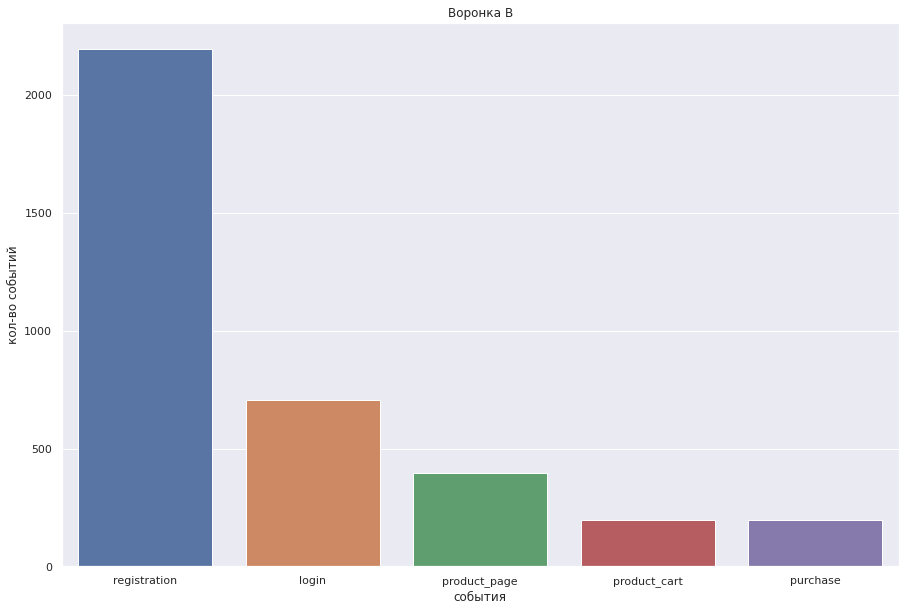

In [48]:
sns.barplot(data=funnel_B, x='event_name', y='user_id')
plt.title('Воронка B')
plt.xlabel('события')
plt.ylabel('кол-во событий')
plt.show()

Итоговая воронка по группе B - готова. Замечено, что значение события "просмотр корзины" меньше, чем у события "покупка". Скорее всего, это объясняется наличием альтернативной опции оплаты покупки, которая не требует использования корзины.

In [49]:
funnel_B['ratio_first'] = round(funnel_B['user_id']/total_B_new*100,2)
funnel_B['ratio_prev'] = round(funnel_B['user_id']/funnel_B['user_id'].shift(1, fill_value=0)*100,2)
funnel_B

,event_name,user_id,ratio_first,ratio_prev
4,registration,2196,100.00,inf
0,login,705,32.10,32.10
2,product_page,397,18.08,56.31
1,product_cart,195,8.88,49.12
3,purchase,198,9.02,101.54


Воронка имеет низкую проходимость на каждом из этапов, что указывает на серьезные проблемы в ее функционировании. Существует предположение, что при настройке новой платежной воронки, была допущена ошибка, приведшая к нарушению функционала воронки и негативно сказавшаяся на его эффективности.

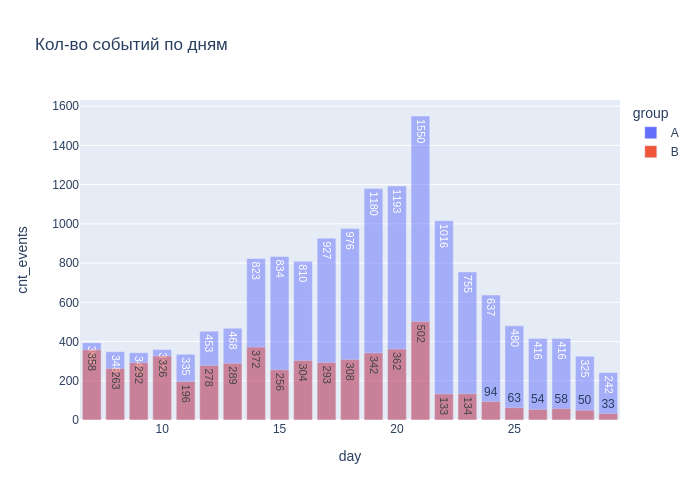

In [50]:
#посмотрим как число событий в выборках распределено по дням между группами
test_ab_new_cnt = (
    test_ab_new.groupby(['day', 'group']).agg({'event_name':'count'})
    .reset_index().sort_values(by='event_name', ascending=False)
)
test_ab_new_cnt.columns = ['day', 'group', 'cnt_events']

fig = px.bar(
    test_ab_new_cnt, 
    x='day', 
    y='cnt_events', 
    color='group', 
    barmode='overlay', 
    text='cnt_events',
    title='Кол-во событий по дням'
)
fig.show()

Значительный рост событий начался в промежутке от 15 до 21 числа, после чего произошел спад. Поэтому тест завершился 30 числа, так как дальнейшее продолжение теста не имело бы смысла из-за снижения количества событий. При этом стоит отметить, что группа А демонстрировала лучшую эффективность на протяжении всего теста, в то время как группа B не оправдала ожиданий.

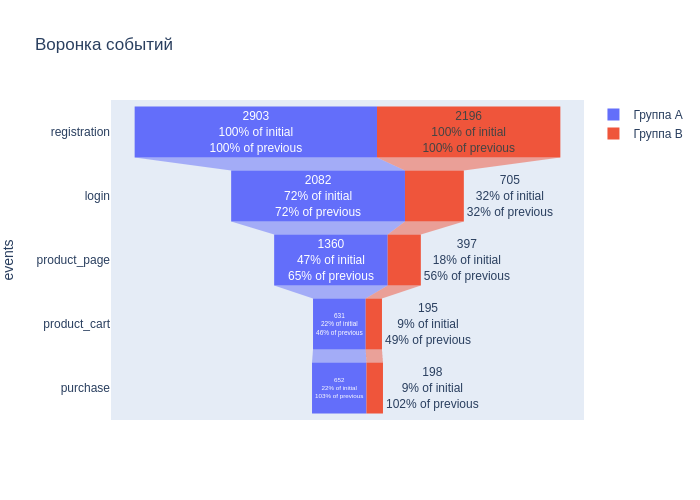

In [51]:
fig = go.Figure()

fig.add_trace(go.Funnel(name='Группа А',
                        y=funnel_A['event_name'],
                        x=funnel_A['user_id'],
                        textinfo="value+percent initial+percent previous"))

fig.add_trace(go.Funnel(name='Группа B',
                        y=funnel_B['event_name'],
                        x=funnel_B['user_id'],
                        textinfo="value+percent initial+percent previous"))

fig.update_layout(title='Воронка событий', yaxis_title='events')
    
fig.show()

In [52]:
#посмотрим пользователей, которые не совершали событий после регистрации
print('Только зарегистрировались -', test_ab_new.query('event_name == "registration"')['user_id'].nunique())

Только зарегистрировались - 2311


In [53]:
test_ab_new.query('event_name == "registration"').groupby('group')['user_id'].nunique()

group
A     821
B    1490
Name: user_id, dtype: int64

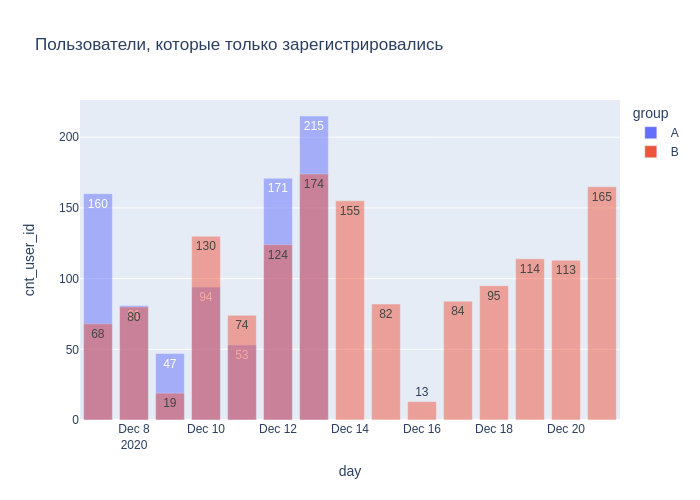

In [54]:
fig = (
    test_ab_new.query('event_name == "registration"')
    .groupby(['event_dt', 'group'])
    .agg({'user_id':'nunique'})
    .reset_index()
    .sort_values(by='user_id', ascending=False)
)

fig.columns = ['day', 'group', 'сnt_user_id']

fig = px.bar(
    fig, 
    x='day', 
    y='сnt_user_id', 
    color='group', 
    barmode='overlay', 
    text='сnt_user_id',
    title='Пользователи, которые только зарегистрировались'
)
fig.show()

In [55]:
(
    test_ab_new.query('event_name == "registration"')
    .groupby(['region'])
    .agg({'user_id':'nunique'})
    .reset_index()
    .sort_values(by='user_id', ascending=False)
)

,region,user_id
2,EU,2155
3,N.America,104
0,APAC,27
1,CIS,25


Почти половина всех участников теста (45%) только зарегистрировались и не продолжили взаимодействие. Среди пользователей из группы B эта доля составила 70%. После 14 числа подобные клиенты сосредоточились только в группе B. Кроме того, практически все пользователи находятся в регионе EU.

 - На протяжении теста группа А демонстрировала лучшую эффективность как в плане конверсии, так и по количеству событий, в то время как группа В оказалась неэффективной с показателями в несколько раз ниже относительно контрольной группы А.
 - Тест был завершен раньше из-за снижения активности пользователей.
 - 45% всех участников теста зарегистрировались. 
 - Результаты теста можно считать провальными из-за низкой эффективности группы В и раннего завершения теста из-за снижения активности пользователей.

## Оценка результата A/B-тестирования

**H_0**: Доля конверсии группы А по каждому этапу и доля конверсии группы В по каждому этапу равны

**H_1**: Доля конверсии группы А по каждому этапу и доля конверсии группы В по каждому этапу не равны

alpha = 0.05

In [56]:
#статистическая разница долей
usr_test_ab_group['total'] = usr_test_ab_group['A'] + usr_test_ab_group['B']
usr_test_ab_group

group
A        2903
B        2196
total    5099
Name: user_id, dtype: int64

In [57]:
funnel = pd.merge(funnel_A[['event_name', 'user_id']], 
                  funnel_B[['event_name', 'user_id']], 
                  on='event_name', 
                  suffixes=('_A', '_B'))

funnel = funnel[funnel['event_name'] != 'registration'].reset_index(drop=True)

funnel.rename(columns={'user_id_A': 'A', 
                       'user_id_B': 'B'}, inplace=True)
funnel['total'] = funnel['A'] + funnel['B']

funnel = funnel[['event_name', 'A', 'B', 'total']]
funnel

,event_name,A,B,total
0,login,2082,705,2787
1,product_page,1360,397,1757
2,product_cart,631,195,826
3,purchase,652,198,850


In [60]:
def z_test (group1, group2, alpha):
    for i in funnel.index: 
        p1=funnel[group1][i]/usr_test_ab_group[group1]
        
        p2=funnel[group2][i]/usr_test_ab_group[group2]
        
        print(funnel[group1][i], funnel[group2][i],usr_test_ab_group[group1] , usr_test_ab_group[group2])
        
        p_combined=((funnel[group1][i]+funnel[group2][i])/(usr_test_ab_group[group1]+usr_test_ab_group[group2]))
        
        difference=p1-p2
        
        z_value=difference/mth.sqrt(p_combined*(1-p_combined)*(1/usr_test_ab_group[group1]+1/usr_test_ab_group[group2]))
        
        distr=stats.norm(0, 1)
        
        p_value=(1-distr.cdf(abs(z_value)))*2 
        
        print ('{} p-значение:{}'.format(funnel['event_name'][i], p_value)) 
        
        if (p_value<alpha ): 
            print('Отвергаем нулевую гипотезу') 
        else: 
            print('Не удалось отвергнуть нулевую гипотезу')

In [61]:
z_test('A', 'B', 0.05)

2082 705 2903 2196
login p-значение:0.0
Отвергаем нулевую гипотезу
1360 397 2903 2196
product_page p-значение:0.0
Отвергаем нулевую гипотезу
631 195 2903 2196
product_cart p-значение:0.0
Отвергаем нулевую гипотезу
652 198 2903 2196
purchase p-значение:0.0
Отвергаем нулевую гипотезу


Между группами между долями есть значимая разница, также это показывает исследовательский анализ

## Вывод и рекомендации

 - Тест можно считать провальным
 - Группа А превосходит группу В по конверсии и количеству событий; группа В оказалась неэффективной, показатели гораздо ниже, чем у контрольной группы А.
 - Тест был прерван из-за снижения активности пользователей в течение его проведения.
 - На протяжении теста проходили маркетинговые активности, которые могли повлиять на результаты теста, возможно, что они были причиной неожиданных результатов.
 - Из-за ошибок в начальной выборке было потеряно 24% данных.
 - Большинство участников теста из региона EU (70%), хотя в других регионах также пользуются приложением

**Рекомендации:**

 - В следующий раз необходимо более подробно готовиться к проведению тестирования. Следует проверять начальную выборку, избегать пересечений с конкурирующими тестами и исключать маркетинговые акции на этапе тестирования.
 - Следует провести проверку приложения на технические аспекты, включая путь клиента, так как около 40% клиентов, зарегистрировавшихся на сайте, не достигают экрана для входа. Однако, группе В была зафиксирована высокая потеря клиентов, возможно, эта группа задевает весь функционал настройки новой платежной воронки.